<a href="https://colab.research.google.com/github/harshitajain523/TransCMFD_Copy_Move_Forgery_Detection/blob/main/COVERAGE_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

from google.colab import drive
drive.mount('/content/drive')

PyTorch version: 2.6.0+cu124
CUDA available: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
COVERAGE_CHECKPOINT_PATH = "/content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth"

# --- Hyperparameters for Initial Training on COVERAGE (from scratch) ---
INITIAL_COVERAGE_LR = 1e-5 # Learning rate for scratch training
COVERAGE_NUM_EPOCHS = 100 # Give it more epochs as it's learning from scratch, but rely on scheduler
COVERAGE_BATCH_SIZE = 2 # Consistent batch size
COVERAGE_GRADIENT_ACCUMULATION_STEPS = 4 # Consistent
COVERAGE_ALPHA = 0.35 # Loss weighting (more emphasis on BCE for boundaries)
COVERAGE_BETA = 0.65 # Loss weighting
COVERAGE_GAMMA = 0.005 # Regularization for deeper model
COVERAGE_SCHEDULER_PATIENCE = 7 # Patience for scheduler


In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.gn = nn.GroupNorm(32, out_channels) # GroupNorm works well when batch size is small or varies
        self.relu = nn.ReLU(inplace=True)
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

class Bridge(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

class UpBlockForUNetWithResNet50(nn.Module):
    def __init__(self, in_channels_after_concat, out_channels, up_conv_in_channels, up_conv_out_channels,
                 upsampling_method="bilinear"):
        super().__init__()

        self.upsampling_method = upsampling_method
        if upsampling_method == "conv_transpose":
            self.upsample_layer = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample_layer = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        else:
            raise ValueError("Unsupported upsampling_method")

        self.conv_block = ConvBlock(in_channels_after_concat, out_channels)

    def forward(self, up_x, down_x):
        up_x = self.upsample_layer(up_x)

        # Handle potential size mismatch after upsampling (due to odd dimensions)
        if up_x.shape[2] != down_x.shape[2] or up_x.shape[3] != down_x.shape[3]:
            up_x = F.interpolate(up_x, size=(down_x.shape[2], down_x.shape[3]), mode='bilinear', align_corners=False)

        x = torch.cat([up_x, down_x], 1)
        x = self.conv_block(x)
        return x

class Encoder(nn.Module):
    # CNN Encoder based on a pre-trained ResNet-50.
    # Modified to use 3 convolution stages, making layer3's output (1024 channels) the deepest.
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)

        # ResNet-50 structure:
        # 0: Conv2d (initial 7x7)
        # 1: BatchNorm2d
        # 2: ReLU
        # 3: MaxPool2d
        # 4: layer1 (residual block, 64 channels out) - spatial size 56x56 for 224x224 input
        # 5: layer2 (residual block, 128 channels out) - spatial size 28x28
        # 6: layer3 (residual block, 256 channels out) - spatial size 14x14
        # 7: layer4 (residual block, 512 channels out) - spatial size 7x7
        # 8: AvgPool2d
        # 9: Linear (FC layer)

        # Input block: initial conv, BN, ReLU, MaxPool
        self.input_block = nn.Sequential(*list(resnet.children()))[:4] # Still corresponds to 64 channels output

        # Down blocks: layer1, layer2, layer3
        # We want to stop before layer4 to get 1024 channels (output of layer3)
        down_blocks = []
        # We need `list(resnet.children())[4:7]` to get layer1, layer2, layer3
        # ResNet's `layer1` outputs 256 channels
        # ResNet's `layer2` outputs 512 channels
        # ResNet's `layer3` outputs 1024 channels
        # ResNet's `layer4` outputs 2048 channels

        # Original code comment suggests channels:
        # layer1: 256, layer2: 512, layer3: 1024, layer4: 2048
        # The structure is: input_block -> 64 channel feature.
        # then layer1 (block 4) outputs 256.
        # layer2 (block 5) outputs 512.
        # layer3 (block 6) outputs 1024.
        # layer4 (block 7) outputs 2048.

        # We will use blocks 4, 5, 6 (layer1, layer2, layer3)
        self.down_blocks = nn.ModuleList(list(resnet.children())[4:7]) # This will include layer1, layer2, layer3

    def forward(self, x):
        pre_pools = dict()
        pre_pools["layer_0"] = x # Original input image for the very last decoder stage (512x512 initially)

        x = self.input_block(x) # Output e.g., (B, 64, 56, 56) for 224x224 input
        pre_pools["layer_1"] = x # Skip connection for decoder's up_block4

        # After input_block, the spatial dims for 224x224 input:
        # Initial 224x224 -> MaxPool (stride 2) -> 112x112 -> MaxPool (stride 2) -> 56x56
        # The first layer of ResNet (layer1) starts operating on 56x56

        # down_blocks contains: layer1, layer2, layer3
        # pre_pools["layer_1"] is the output of input_block (64 channels, spatial 56x56)
        # pre_pools["layer_2"] will be output of layer1 (256 channels, spatial 56x56)
        # pre_pools["layer_3"] will be output of layer2 (512 channels, spatial 28x28)
        # pre_pools["layer_4"] will be output of layer3 (1024 channels, spatial 14x14) - this is the deepest feature

        # The loop now runs for 3 blocks (layer1, layer2, layer3)
        for i, block in enumerate(self.down_blocks):
            x = block(x)
            # Store skip connections. layer_i+2 maps to pre_pools:
            # i=0 (layer1): x is output of layer1. Store as pre_pools["layer_2"]
            # i=1 (layer2): x is output of layer2. Store as pre_pools["layer_3"]
            # i=2 (layer3): x is output of layer3. This is the deepest feature; it goes to bridge/transformer.
            # We don't store it as a 'pre_pool' because it's directly passed to the bridge.
            if i < len(self.down_blocks) - 1: # ALL but the last one (layer3 output is going to bridge)
                pre_pools[f"layer_{i+2}"] = x

        # `x` here is the output of layer3 (1024 channels, 14x14 spatial for 224x224 input)
        return x, pre_pools

class Decoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        # Decoder stages:
        # For 224x224 input, spatial resolutions are:
        # Encoder: Input -> 56x56 (input_block/layer1) -> 28x28 (layer2) -> 14x14 (layer3/bridge)
        # Decoder stages will upsample: 14x14 -> 28x28 -> 56x56 -> 112x112 -> 224x224

        # Up-block 1: Fuses deepest feature (from bridge/transformer output) with ResNet.layer2 output
        # up_x (from bridge) is 1024 channels, 14x14. Skip (pre_pools["layer_3"]) is 512 channels, 28x28.
        # Up-x after upsample becomes 1024 channels, 28x28.
        # Concatenated: 1024 + 512 = 1536 channels. Output: 512 channels, 28x28 spatial.
        self.up_block1 = UpBlockForUNetWithResNet50(
            in_channels_after_concat=1024 + 512, out_channels=512,
            up_conv_in_channels=1024, up_conv_out_channels=1024,
            upsampling_method="conv_transpose"
        )
        # Up-block 2: Fuses output of up_block1 with ResNet.layer1 output
        # up_x (from up_block1) is 512 channels, 28x28. Skip (pre_pools["layer_2"]) is 256 channels, 56x56.
        # Up-x after upsample becomes 512 channels, 56x56.
        # Concatenated: 512 + 256 = 768 channels. Output: 256 channels, 56x56 spatial.
        self.up_block2 = UpBlockForUNetWithResNet50(
            in_channels_after_concat=512 + 256, out_channels=256,
            up_conv_in_channels=512, up_conv_out_channels=512,
            upsampling_method="conv_transpose"
        )
        # Up-block 3: Fuses output of up_block2 with Encoder's input_block output
        # up_x (from up_block2) is 256 channels, 56x56. Skip (pre_pools["layer_1"]) is 64 channels, 56x56.
        # Concatenated: 256 + 64 = 320 channels. Output: 128 channels, 56x56 spatial.
        self.up_block3 = UpBlockForUNetWithResNet50(
            in_channels_after_concat=256 + 64, out_channels=128,
            up_conv_in_channels=256, up_conv_out_channels=256,
            upsampling_method="conv_transpose"
        )

        # Up-block 4: Fuses output of up_block3 with original input (pre_pools["layer_0"])
        # up_x (from up_block3) is 128 channels, 56x56.
        # up-x after upsample becomes 128 channels, 112x112
        # Original input (pre_pools["layer_0"]) is 3 channels, 224x224.

        self.upsample_to_112 = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        self.conv_after_upsample_112 = ConvBlock(128, 64) # Reduce channels after upsampling

        # Second upsample from 112x112 to 224x224 and final convolution
        self.upsample_to_224 = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        # Concatenate with pre_pools["layer_0"] (the original input image)
        # After self.conv_after_upsample_112, we have 64 channels.
        # Original input (pre_pools["layer_0"]) has 3 channels.
        # So, in_channels_after_concat will be 64 + 3 = 67.
        self.final_conv_block = ConvBlock(in_channels=64 + 3, out_channels=64)

        # Output layer
        self.out = nn.Conv2d(64, n_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x, pre_pools):
        # x is the deepest feature (from bridge/transformer path), 14x14 spatial
        x = self.up_block1(x, pre_pools["layer_3"]) # Output: 512 channels, 28x28 spatial
        x = self.up_block2(x, pre_pools["layer_2"]) # Output: 256 channels, 56x56 spatial
        x = self.up_block3(x, pre_pools["layer_1"]) # Output: 128 channels, 56x56 spatial

        # upsample from 56x56 to 224x224 (target original input size)
        # 56x56 -> 112x112
        x = self.upsample_to_112(x) # 128 channels, 112x112
        x = self.conv_after_upsample_112(x) # 64 channels, 112x112

        # 112x112 -> 224x224, then concatenate with original input (pre_pools["layer_0"])
        x = self.upsample_to_224(x) # 64 channels, 224x224

        # Concatenate with original input image (pre_pools["layer_0"])
        # Ensure sizes match, although interpolate in up_block handles this.
        # But here, we explicitly concatenate the final upsampled feature with the original input.
        # Original input `pre_pools["layer_0"]` is (B, 3, 224, 224)
        x = torch.cat([x, pre_pools["layer_0"]], 1) # (B, 64+3, 224, 224)

        x = self.final_conv_block(x) # (B, 64, 224, 224)

        x = self.out(x) # (B, n_classes, 224, 224)
        return x

# CRITICAL FIX: Enhanced Numerical Stability for FSM with explicit float32 casting
class FeatureSimilarityModule(nn.Module):
    def __init__(self):
        super(FeatureSimilarityModule, self).__init__()
        self.K = 32 # Number of top similarities to select

    def forward(self, feature_map):
        batch_size, channels, H, W = feature_map.shape
        block_size_spatial = 16
        num_blocks_h = H // block_size_spatial
        num_blocks_w = W // block_size_spatial
        num_blocks = num_blocks_h * num_blocks_w

        blocks_unfolded = feature_map.unfold(2, block_size_spatial, block_size_spatial).unfold(3, block_size_spatial, block_size_spatial)
        blocks_flat = blocks_unfolded.permute(0, 2, 3, 1, 4, 5).contiguous().view(batch_size, num_blocks, -1)

        original_dtype = blocks_flat.dtype

        blocks_flat_f32 = blocks_flat.float() # Cast to float32, this is base for FSM calcs

        mean = torch.mean(blocks_flat_f32, dim=2, keepdim=True)
        centered_blocks = blocks_flat_f32 - mean

        epsilon_val = 1e-3 # Keeping this for general stability

        std = torch.std(blocks_flat_f32, dim=2, keepdim=True, unbiased=False)
        std_safe = std + epsilon_val
        normalized_blocks = centered_blocks / std_safe
        clip_val = 1000.0
        normalized_blocks = torch.clamp(normalized_blocks, -clip_val, clip_val)

        # CRITICAL FIX: Explicitly ensure matmul operands are float32 right before the operation.
        A_matmul = normalized_blocks.float() # Ensure float32.
        B_matmul = normalized_blocks.transpose(1, 2).float().contiguous() # Ensure float32 and contiguous
        # Temporarily disable autocast for the matmul operation
        original_autocast_state = torch.is_autocast_enabled()
        torch.set_autocast_enabled(False) # Disable autocast globally

        try:
          similarity_matrix = torch.matmul(A_matmul, B_matmul)
        finally:
          torch.set_autocast_enabled(original_autocast_state) # Re-enable it

        D_block = blocks_flat_f32.shape[2]
        similarity_matrix = similarity_matrix / D_block

        # CRITICAL: Add clamping before converting back to original_dtype (float16)
        if original_dtype == torch.float16:
            similarity_matrix = torch.clamp(similarity_matrix, min=-65500.0, max=65500.0) # Ensure values fit within FP16 range

        similarity_matrix = similarity_matrix.to(original_dtype)

        # Percentile Pooling Block: Select top K similarities
        percentile_scores = torch.zeros(batch_size, num_blocks, self.K,
                                        device=feature_map.device, dtype=similarity_matrix.dtype)

        for b in range(batch_size):
            top_k_scores, _ = torch.topk(similarity_matrix[b], k=self.K, dim=-1, largest=True, sorted=True)
            percentile_scores[b] = top_k_scores

        return percentile_scores

# Adaptive Transformer Components
# Custom Adaptive Multi-Head Self-Attention for the transformer's core innovation
class AdaptiveMultiHeadSelfAttention(nn.Module):
    """
    Custom Adaptive Multi-Head Self-Attention (AdaptiveMSA) module.
    Implements the Dual-Path Adaptive Attention Mechanism (DPAAM).
    """
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.S1 = nn.Parameter(torch.zeros(embed_dim))
        self.S2 = nn.Parameter(torch.zeros(embed_dim))

        self.b1 = nn.Parameter(torch.zeros(embed_dim))
        self.b2 = nn.Parameter(torch.zeros(embed_dim))

        self.epsilon = nn.Parameter(torch.tensor(0.5))
        self.delta = nn.Parameter(torch.tensor(0.5))
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size, seq_len, embed_dim = query.size()

        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_probs = F.softmax(attention_weights, dim=-1)

        Head_prime = torch.matmul(attention_probs, V)
        Head_prime_combined = Head_prime.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        M1_Head = self.S1 * Head_prime_combined + self.b1
        M2_Head = self.S2 * Head_prime_combined + self.b2

        epsilon_val = torch.sigmoid(self.epsilon)
        delta_val = torch.sigmoid(self.delta)

        adaptive_heads_combined = epsilon_val * M1_Head + delta_val * M2_Head

        output = self.out_proj(adaptive_heads_combined)
        return output

class AdaptiveMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.S1 = nn.Parameter(torch.zeros(embed_dim))
        self.S2 = nn.Parameter(torch.zeros(embed_dim))
        self.b1 = nn.Parameter(torch.zeros(embed_dim))
        self.b2 = nn.Parameter(torch.zeros(embed_dim))

        # These parameters are now used for adaptive weighting
        self.epsilon = nn.Parameter(torch.tensor(0.5))
        self.delta = nn.Parameter(torch.tensor(0.5))

        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size, seq_len, embed_dim = query.size()

        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attention_weights = torch.matmul(Q, K.transpose(-2,-1)) / (self.head_dim ** 0.5)
        attention_probs = F.softmax(attention_weights, dim=-1)

        Head_prime = torch.matmul(attention_probs, V)
        Head_prime_combined = Head_prime.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        M1_Head = self.S1 * Head_prime_combined + self.b1
        M2_Head = self.S2 * Head_prime_combined + self.b2

        epsilon_val = torch.sigmoid(self.epsilon)
        delta_val = torch.sigmoid(self.delta)

        adaptive_heads_combined = epsilon_val * M1_Head + delta_val * M2_Head

        output = self.out_proj(adaptive_heads_combined)
        return output

class AdaptiveTransformerLayer(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.adaptive_mhsa = AdaptiveMultiHeadSelfAttention(embed_dim=dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        attn_output = self.adaptive_mhsa(x, x, x)
        x = self.norm1(x + attn_output)
        x_mlp = self.mlp(x)
        x = self.norm2(x + x_mlp)
        return x

class AdaptiveTransformerEncoder(nn.Module):
    def __init__(self, dim, num_heads, num_layers, input_spatial_size):
        super().__init__()
        self.dim = dim
        self.num_layers = num_layers
        self.input_spatial_size = input_spatial_size
        self.layers = nn.ModuleList([AdaptiveTransformerLayer(dim, num_heads) for _ in range(num_layers)])
        self.proj_to_dim = nn.Conv2d(1024, dim, kernel_size=1)
        self.pos_embedding = nn.Parameter(torch.randn(1, input_spatial_size * input_spatial_size, dim))

    def forward(self, feature_map_c_deepest):
        x = self.proj_to_dim(feature_map_c_deepest)
        x = x.flatten(2).permute(0, 2, 1)
        if x.shape[1] != self.pos_embedding.shape[1]:
            raise ValueError(f"Positional embedding sequence length mismatch. Expected {self.pos_embedding.shape[1]}, got {x.shape[1]}")
        x = x + self.pos_embedding
        for layer in self.layers:
            x = layer(x)
        return x

class TransCMFDBaseline(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.encoder = Encoder()
        self.bridge = Bridge(1024, 1024)

        transformer_dim = 512
        transformer_heads = 8
        transformer_layers =6
        transformer_input_spatial_size = 14

        self.adaptive_transformer_encoder = AdaptiveTransformerEncoder(
            dim=transformer_dim,
            num_heads=transformer_heads,
            num_layers=transformer_layers,
            input_spatial_size=transformer_input_spatial_size
        )
        self.transformer_output_to_fsm_input = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)
        self.fsm = FeatureSimilarityModule()
        self.fsm_output_fusion_transform = nn.Conv2d(self.fsm.K, 1024, kernel_size=1)
        self.decoder = Decoder(n_classes=n_classes)

    def forward(self, x):
        encoder_output_c_deepest, pre_pools = self.encoder(x)

        x_bridge = self.bridge(encoder_output_c_deepest)

        transformer_output_tokens = self.adaptive_transformer_encoder(encoder_output_c_deepest)

        fsm_input_spatial_reshaped = transformer_output_tokens.permute(0, 2, 1).contiguous().view(
            transformer_output_tokens.size(0),
            self.adaptive_transformer_encoder.dim,
            self.adaptive_transformer_encoder.input_spatial_size,
            self.adaptive_transformer_encoder.input_spatial_size
        )
        fsm_input = self.transformer_output_to_fsm_input(fsm_input_spatial_reshaped)
        fsm_output_raw = self.fsm(fsm_input)
        fsm_output_spatial_for_fusion = fsm_output_raw.permute(0, 2, 1).contiguous().view(
            fsm_output_raw.size(0), self.fsm.K, 16, 16
        )
        fsm_output_fused = self.fsm_output_fusion_transform(fsm_output_spatial_for_fusion)
        fsm_output_fused_interpolated = F.interpolate(
            fsm_output_fused,
            size=(x_bridge.shape[2], x_bridge.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        fused_decoder_input = x_bridge + fsm_output_fused_interpolated
        output = self.decoder(fused_decoder_input, pre_pools)
        return output

if __name__ == '__main__':
    print("Initializing TransCMFDBaseline model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransCMFDBaseline().to(device)
    print(f"TransCMFDBaseline model successfully loaded on {device}.")

    # print("\n--- Model Architecture Summary ---")
    # print(model)
    # print("----------------------------------\n")
    dummy_transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dummy_input_raw = torch.rand((2, 3, 224, 224))
    dummy_input = dummy_transform(dummy_input_raw).to(device)

    print(f"Dummy input shape: {dummy_input.shape}")

    with torch.no_grad():
        output = model(dummy_input)

    print(f"Output shape: {output.shape}")


Initializing TransCMFDBaseline model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TransCMFDBaseline model successfully loaded on cuda.
Dummy input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 1, 224, 224])


In [4]:
import os
import shutil
import random
from torch.utils.data import Dataset # Ensure this is imported if not already
from tqdm.notebook import tqdm # Ensure this is imported if not already
import torchvision.transforms as transforms # Ensure this is imported
from PIL import Image # Ensure this is imported for CMFDataset_COVERAGE

# --- IMPORTANT: Create these target folders on your Google Drive first! ---
# /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/train/images
# /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/train/masks
# /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/val/images
# /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/val/masks
# /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/test/images
# /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/test/masks
# -------------------------------------------------------------------------

# --- Your CMFDataset_COVERAGE Class Definition (Copy-paste here if not already in an earlier cell you run) ---
# This must be the *corrected* version that handles 't.tif' and '_forged.tif' correctly.
class CMFDataset_COVERAGE(Dataset):
    def __init__(self, data_root, image_transform=None, mask_transform=None):
        self.data_root = data_root
        self.image_folder = os.path.join(data_root, 'image')
        self.mask_folder = os.path.join(data_root, 'mask ')

        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.data_pairs = []

        tampered_image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.lower().endswith('t.tif')])

        for img_name_tampered in tampered_image_filenames:
            img_path = os.path.join(self.image_folder, img_name_tampered)

            base_name = img_name_tampered.replace('t.tif', '')

            mask_name_forged = f"{base_name}forged.tif"
            mask_path = os.path.join(self.mask_folder, mask_name_forged)

            if os.path.exists(mask_path):
                self.data_pairs.append((img_path, mask_path))
            else:
                print(f"Warning: Forged mask '{mask_name_forged}' not found for image '{img_name_tampered}' at '{mask_path}'. Skipping.")

        print(f"Loaded {len(self.data_pairs)} valid tampered image-mask pairs from COVERAGE dataset at {data_root}")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.data_pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image_tensor = self.image_transform(image)
        else:
            image_tensor = transforms.ToTensor()(image)

        if self.mask_transform:
            mask_tensor = self.mask_transform(mask)
        else:
            mask_tensor = transforms.ToTensor()(mask)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor
# --- End of CMFDataset_COVERAGE Class Definition ---


# --- Define data transforms (just basic ToTensor for temporary loading for splitting script) ---
TEMP_IMAGE_TRANSFORM = transforms.Compose([transforms.ToTensor()])
TEMP_MASK_TRANSFORM = transforms.Compose([transforms.ToTensor()])

# --- Define original COVERAGE root ---
COVERAGE_ROOT_ORIGINAL = '/content/drive/MyDrive/TransCMFD_dataset/COVERAGE'
full_coverage_dataset_temp = CMFDataset_COVERAGE(
    data_root=COVERAGE_ROOT_ORIGINAL,
    image_transform=TEMP_IMAGE_TRANSFORM,
    mask_transform=TEMP_MASK_TRANSFORM
)

all_data_pairs = full_coverage_dataset_temp.data_pairs
print(f"Total valid COVERAGE pairs found for splitting: {len(all_data_pairs)}")

# --- Define split ratios ---
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15 # Ensure train_ratio + val_ratio + test_ratio = 1.0

# --- Calculate split sizes ---
total_samples = len(all_data_pairs)
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size # Assign remaining to test

# --- Randomly split the indices ---
random.shuffle(all_data_pairs) # Shuffle the list of (image_path, mask_path) tuples

train_pairs = all_data_pairs[0:train_size]
val_pairs = all_data_pairs[train_size : train_size + val_size]
test_pairs = all_data_pairs[train_size + val_size :]

print(f"Split sizes: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")

# --- Define target directories for the split ---
COVERAGE_ROOT_SPLIT = '/content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT'

split_dirs = {
    'train': {'images': os.path.join(COVERAGE_ROOT_SPLIT, 'train', 'images'), 'masks': os.path.join(COVERAGE_ROOT_SPLIT, 'train', 'masks')},
    'val':   {'images': os.path.join(COVERAGE_ROOT_SPLIT, 'val', 'images'),   'masks': os.path.join(COVERAGE_ROOT_SPLIT, 'val', 'masks')},
    'test':  {'images': os.path.join(COVERAGE_ROOT_SPLIT, 'test', 'images'),  'masks': os.path.join(COVERAGE_ROOT_SPLIT, 'test', 'masks')},
}

# --- Create directories if they don't exist ---
for split_type in split_dirs:
    os.makedirs(split_dirs[split_type]['images'], exist_ok=True)
    os.makedirs(split_dirs[split_type]['masks'], exist_ok=True)
    print(f"Created directories for {split_type}")

# --- Copy files to new directories (resuming if files exist) ---
print("\nCopying files to split directories (resuming if files exist)...")
for split_type, pairs_list in {'train': train_pairs, 'val': val_pairs, 'test': test_pairs}.items():
    print(f"Processing {split_type} split ({len(pairs_list)} files)...")
    for img_path, mask_path in tqdm(pairs_list, desc=f"Copying {split_type} files"):
        img_filename = os.path.basename(img_path)
        mask_filename = os.path.basename(mask_path)

        # Define destination paths
        dest_img_path = os.path.join(split_dirs[split_type]['images'], img_filename)
        dest_mask_path = os.path.join(split_dirs[split_type]['masks'], mask_filename)

        # Check if the image file already exists in the destination
        if not os.path.exists(dest_img_path):
            try:
                shutil.copy2(img_path, dest_img_path)
            except Exception as e:
                print(f"Error copying image {img_filename} to {dest_img_path}: {e}")

        # Check if the mask file already exists in the destination
        if not os.path.exists(dest_mask_path):
            try:
                shutil.copy2(mask_path, dest_mask_path)
            except Exception as e:
                print(f"Error copying mask {mask_filename} to {dest_mask_path}: {e}")
print("\nFile copying complete. COVERAGE dataset is now split (or resumed)!")

Loaded 100 valid tampered image-mask pairs from COVERAGE dataset at /content/drive/MyDrive/TransCMFD_dataset/COVERAGE
Total valid COVERAGE pairs found for splitting: 100
Split sizes: Train=70, Val=15, Test=15
Created directories for train
Created directories for val
Created directories for test

Copying files to split directories (resuming if files exist)...
Processing train split (70 files)...


Copying train files:   0%|          | 0/70 [00:00<?, ?it/s]

Processing val split (15 files)...


Copying val files:   0%|          | 0/15 [00:00<?, ?it/s]

Processing test split (15 files)...


Copying test files:   0%|          | 0/15 [00:00<?, ?it/s]


File copying complete. COVERAGE dataset is now split (or resumed)!


In [5]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, prediction, target):
        target = target.float()
        prediction = torch.sigmoid(prediction) #sigmoid for conversion to probabilities
        prediction_flat = prediction.contiguous().view(-1)
        target_flat = target.contiguous().view(-1)
        intersection = (prediction_flat * target_flat).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (prediction_flat.sum() + target_flat.sum() + self.smooth)
        return 1 - dice_coefficient
# CORRECTED AdaptiveRegularizationLoss
class AdaptiveRegularizationLoss(nn.Module):
    def __init__(self):
        super(AdaptiveRegularizationLoss, self).__init__() # [cite: 171]

    def forward(self, model):
        l_adapt_total = 0.0
        if hasattr(model, 'adaptive_transformer_encoder') and \
           hasattr(model.adaptive_transformer_encoder, 'layers'):
            for layer in model.adaptive_transformer_encoder.layers:
                if hasattr(layer, 'adaptive_mhsa'):
                    s1_param = layer.adaptive_mhsa.S1
                    s2_param = layer.adaptive_mhsa.S2
                    # CORRECTED: Changed to positive sum of squared L2 norms for regularization
                    l_adapt_total += torch.norm(s1_param, 2)**2
                    l_adapt_total += torch.norm(s2_param, 2)**2
        return l_adapt_total

dice_loss_fn = DiceLoss(smooth=1.0)
bce_loss_fn = nn.BCEWithLogitsLoss()
adaptive_reg_loss_fn = AdaptiveRegularizationLoss()

In [6]:
# Cell X: CMFDataset_COVERAGE_Split Class Definition

import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms # Ensure this is imported

class CMFDataset_COVERAGE_Split(Dataset):
    def __init__(self, root_dir, split_type, image_transform=None, mask_transform=None, paired_transforms=None):
        # root_dir would be '/content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT'
        # split_type would be 'train', 'val', or 'test'
        self.image_folder = os.path.join(root_dir, split_type, 'images')
        self.mask_folder = os.path.join(root_dir, split_type, 'masks')

        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.paired_transforms = paired_transforms # New parameter for paired transforms
        self.data_pairs = []

        # List all image files in the current split's image folder (e.g., 'train/images')
        # These are assumed to be tampered images with 't.tif' suffix.
        image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.lower().endswith('t.tif')])

        for img_name_tampered in image_filenames:
            img_path = os.path.join(self.image_folder, img_name_tampered)

            # Derive the base name for the mask from the image filename (e.g., '1t.tif' -> '1')
            base_name = img_name_tampered.replace('t.tif', '')

            # Construct the corresponding forged mask filename (e.g., '1forged.tif')
            mask_name_forged = f"{base_name}forged.tif"
            mask_path = os.path.join(self.mask_folder, mask_name_forged)

            # For fixed splits, we assume all masks are present after the splitting script
            if os.path.exists(mask_path):
                self.data_pairs.append((img_path, mask_path))
            else:
                # If this prints an error, it means the splitting script didn't copy the mask
                print(f"ERROR: Mask '{mask_name_forged}' NOT FOUND for image '{img_name_tampered}' in '{split_type}' split folder! Data integrity issue after split.")

        print(f"Loaded {len(self.data_pairs)} samples for '{split_type}' split from {self.image_folder}")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.data_pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply paired transforms here BEFORE other transforms
        if self.paired_transforms:
            for transform_op in self.paired_transforms:
                image, mask = transform_op(image, mask)

        if self.image_transform:
            image_tensor = self.image_transform(image)
        else: # Should always be provided
            image_tensor = transforms.ToTensor()(image)

        if self.mask_transform:
            mask_tensor = self.mask_transform(mask)
        else: # Should always be provided
            mask_tensor = transforms.ToTensor()(mask)
        mask_tensor = (mask_tensor > 0.5).float() # Ensure mask is strictly binary

        return image_tensor, mask_tensor

In [7]:
# --- Your train_model function definition ---
def train_model(model, train_loader, val_loader, optimizer, dice_loss,
                bce_loss, adaptive_reg_loss, num_epochs, alpha, beta, gamma,
                scheduler=None, gradient_accumulation_steps=1, checkpoint_save_path="best_model.pth"):

    model.train()
    device = next(model.parameters()).device
    scaler = torch.cuda.amp.GradScaler(enabled=True)

    best_val_loss = float('inf')
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        optimizer.zero_grad()

        for batch_idx, (images, masks) in enumerate(train_loop):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            if torch.isnan(images).any() or torch.isinf(images).any():
                print(f"Warning: NaN or Inf found in images at batch {batch_idx}! Skipping batch.")
                optimizer.zero_grad()
                continue
            if torch.isnan(masks).any() or torch.isinf(masks).any():
                print(f"Warning: NaN or Inf found in masks at batch {batch_idx}! Skipping batch.")
                optimizer.zero_grad()
                continue

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                predictions = model(images)

                # Removed verbose debug prints for predictions
                # if (batch_idx % 10 == 0) or torch.isnan(predictions).any() or torch.isinf(predictions).any():
                #     pred_min = predictions.min().item()
                #     pred_max = predictions.max().item()
                #     pred_mean = predictions.mean().item()
                #     # print(f"\nBatch {batch_idx}: Pred Logits Min: {pred_min:.4f}, Max: {pred_max:.4f}, Mean: {pred_mean:.4f}")

                if torch.isnan(predictions).any() or torch.isinf(predictions).any():
                    print(" !!! NaN or Inf detected in predictions BEFORE loss calculation !!!")
                    raise ValueError("NaN/Inf predictions detected. Stopping for debug.")

                l_dice = dice_loss(predictions, masks)
                l_bce = bce_loss(predictions, masks)
                l_adapt = adaptive_reg_loss(model)
                total_loss = alpha * l_dice + beta * l_bce + gamma * l_adapt
                total_loss = total_loss / gradient_accumulation_steps

            # Removed verbose NaN/Inf checks for losses, but kept raise ValueError
            if torch.isnan(total_loss):
                if torch.isnan(l_dice) or torch.isnan(l_bce) or torch.isnan(l_adapt):
                    print(f"\n !!! NaN in a loss component at batch {batch_idx}! ")
                    print(f" l_dice: {l_dice.item() if not torch.isnan(l_dice) else 'NaN'}")
                    print(f" l_bce: {l_bce.item() if not torch.isnan(l_bce) else 'NaN'}")
                    print(f" l_adapt: {l_adapt.item() if not torch.isnan(l_adapt) else 'NaN'}")
                raise ValueError(f"NaN total loss detected at batch {batch_idx}. Component issue suspected.")


            scaler.scale(total_loss).backward()

            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += total_loss.item() * images.size(0) * gradient_accumulation_steps
            train_loop.set_postfix(loss=total_loss.item() * gradient_accumulation_steps)

        if (batch_idx + 1) % gradient_accumulation_steps != 0: # Handle remaining gradients from last partial batch
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
            for images, masks in val_loop:
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)

                with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                    predictions = model(images)
                    l_dice_val = dice_loss(predictions, masks)
                    l_bce_val = bce_loss(predictions, masks)
                    l_adapt_val = adaptive_reg_loss(model)
                    total_val_loss = alpha * l_dice_val + beta * l_bce_val + gamma * l_adapt_val

                val_loss += total_val_loss.item() * images.size(0)
                val_loop.set_postfix(val_loss=total_val_loss.item())

            epoch_val_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}")

            if scheduler:
                scheduler.step(epoch_val_loss)

            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                os.makedirs(os.path.dirname(checkpoint_save_path), exist_ok=True)
                torch.save(model.state_dict(), checkpoint_save_path)
                print(f"Model saved to {checkpoint_save_path} with validation loss: {best_val_loss:.4f}")

    print("\nTraining complete!")

In [15]:
# Cell X: COVERAGE Scratch Training Notebook (Adapted for Split Data)

# --- Ensure all necessary imports are at the top of this notebook ---
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the path for saving the best COVERAGE scratch model
COVERAGE_SCRATCH_CHECKPOINT_PATH = "/content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth"

# --- Hyperparameters for Initial Training on COVERAGE (from scratch) ---
INITIAL_COVERAGE_LR = 1e-4 # Learning rate for scratch training
COVERAGE_NUM_EPOCHS = 100 # Give it more epochs as it's learning from scratch, but rely on scheduler
COVERAGE_BATCH_SIZE = 4 # Consistent batch size
COVERAGE_GRADIENT_ACCUMULATION_STEPS = 4 # Consistent
COVERAGE_ALPHA = 0.35 # Loss weighting (more emphasis on BCE for boundaries)
COVERAGE_BETA = 0.65 # Loss weighting
COVERAGE_GAMMA = 0.003 # Regularization for deeper model
COVERAGE_SCHEDULER_PATIENCE = 7 # Patience for scheduler


# --- Model Class Definitions ---
# Copy-paste all your model class definitions here (ConvBlock, TransCMFDBaseline etc.)
# Ensure ConvTranspose2d is used in the decoder for better boundaries, and debug prints are commented out.
# ... (all model class definitions from previous setup) ...

# --- Loss Function Definitions ---
# Copy-paste your DiceLoss, AdaptiveRegularizationLoss class definitions, and their instantiation.
# ... (DiceLoss, AdaptiveRegularizationLoss, dice_loss_fn, bce_loss_fn, adaptive_reg_loss_fn definitions) ...

# --- train_model Function Definition ---
# Copy-paste your train_model function definition.
# ... (train_model function definition) ...


import torchvision.transforms.functional as TF # CORRECTED IMPORT
import torchvision.transforms as transforms # Import transforms to access InterpolationMode

class PairedRandomRotation:
    def __init__(self, degrees):
        if isinstance(degrees, (int, float)):
            self.degrees = (-abs(degrees), abs(degrees))
        else:
            self.degrees = degrees

    def __call__(self, img, mask):
        angle = transforms.RandomRotation.get_params(self.degrees)

        # CORRECTED: Use 'interpolation' instead of 'resample'
        img = TF.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR) # Use BILINEAR for image
        mask = TF.rotate(mask, angle, interpolation=transforms.InterpolationMode.NEAREST) # Use NEAREST for mask
        return img, mask

class PairedRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        return img, mask

# 2. Define composite transforms for training and validation
# For Training (includes geometric and color augmentation)
TRAIN_IMAGE_TRANSFORM_COVERAGE = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Only apply to image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TRAIN_MASK_TRANSFORM_COVERAGE = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float() # Ensure mask is strictly binary
])

# For Validation and Testing (no augmentation)
EVAL_IMAGE_TRANSFORM_COVERAGE = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

EVAL_MASK_TRANSFORM_COVERAGE = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

# Define paired transforms for the training dataset ONLY
PAIRED_TRAIN_TRANSFORMS_COVERAGE = [
    PairedRandomHorizontalFlip(p=0.5),
    PairedRandomRotation(degrees=10) # Rotate by max 10 degrees
]


# --- Main Execution Block for COVERAGE Scratch Training ---
# Define COVERAGE root path for the *split* dataset
COVERAGE_ROOT_SPLIT = '/content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT'

# Instantiate datasets for each split using the new CMFDataset_COVERAGE_Split class
# This assumes you have already run the splitting script for COVERAGE.
train_dataset_coverage = CMFDataset_COVERAGE_Split(
    root_dir=COVERAGE_ROOT_SPLIT,
    split_type='train',
    image_transform=TRAIN_IMAGE_TRANSFORM_COVERAGE,
    mask_transform=TRAIN_MASK_TRANSFORM_COVERAGE,
    paired_transforms=PAIRED_TRAIN_TRANSFORMS_COVERAGE # Pass paired transforms for train set
)

val_dataset_coverage = CMFDataset_COVERAGE_Split(
    root_dir=COVERAGE_ROOT_SPLIT,
    split_type='val',
    image_transform=EVAL_IMAGE_TRANSFORM_COVERAGE,
    mask_transform=EVAL_MASK_TRANSFORM_COVERAGE,
    paired_transforms=None # No paired transforms for validation
)

test_dataset_coverage = CMFDataset_COVERAGE_Split(
    root_dir=COVERAGE_ROOT_SPLIT,
    split_type='test',
    image_transform=EVAL_IMAGE_TRANSFORM_COVERAGE,
    mask_transform=EVAL_MASK_TRANSFORM_COVERAGE,
    paired_transforms=None # No paired transforms for testing
)

print(f"COVERAGE Dataset split loaded from folders: Training {len(train_dataset_coverage)} samples, Validation {len(val_dataset_coverage)} samples, Test {len(test_dataset_coverage)} samples")

train_loader_coverage = DataLoader(
    train_dataset_coverage,
    batch_size=COVERAGE_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader_coverage = DataLoader(
    val_dataset_coverage,
    batch_size=COVERAGE_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader_coverage = DataLoader( # Define test_loader for later evaluation
    test_dataset_coverage,
    batch_size=COVERAGE_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"COVERAGE Train DataLoader batches: {len(train_loader_coverage)}")
print(f"COVERAGE Validation DataLoader batches: {len(val_loader_coverage)}")
print(f"COVERAGE Test DataLoader batches: {len(test_loader_coverage)}")


# --- Test Data Loading ---
print("\nTesting COVERAGE data loading (Train split)...")
try:
    images, masks = next(iter(train_loader_coverage))
    print(f"Batch images shape: {images.shape}")
    print(f"Batch images dtype: {images.dtype}")
    print(f"Batch masks shape: {masks.shape}")
    print(f"Batch masks dtype: {masks.dtype}")
    print("COVERAGE Data loading successful!")
except Exception as e:
    print(f"Error during COVERAGE data loading test: {e}")
    print(f"Please double-check your COVERAGE_ROOT_SPLIT path and split folder structure (train/images, train/masks etc.) for {COVERAGE_ROOT_SPLIT}.")


# --- Instantiate a BRAND NEW Model (for scratch training) ---
model_coverage_scratch = TransCMFDBaseline(n_classes=1).to(device)

# --- Define Optimizer and Scheduler for Scratch Training ---
optimizer_scratch = optim.Adam(model_coverage_scratch.parameters(), lr=INITIAL_COVERAGE_LR)
scheduler_scratch = ReduceLROnPlateau(
    optimizer_scratch, mode='min', factor=0.1, patience=COVERAGE_SCHEDULER_PATIENCE, verbose=True, min_lr=1e-7
)

# --- Start COVERAGE Scratch Training! ---
print(f"\n--- Starting Training from Scratch on COVERAGE Dataset (Split Data) ---")
train_model(
    model_coverage_scratch,
    train_loader_coverage,
    val_loader_coverage,
    optimizer_scratch,
    dice_loss_fn,
    bce_loss_fn,
    adaptive_reg_loss_fn,
    COVERAGE_NUM_EPOCHS,
    COVERAGE_ALPHA,
    COVERAGE_BETA,
    COVERAGE_GAMMA,
    scheduler=scheduler_scratch,
    gradient_accumulation_steps=COVERAGE_GRADIENT_ACCUMULATION_STEPS,
    checkpoint_save_path=COVERAGE_SCRATCH_CHECKPOINT_PATH # Save to new path
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Loaded 100 samples for 'train' split from /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/train/images
Loaded 63 samples for 'val' split from /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/val/images
Loaded 53 samples for 'test' split from /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/test/images
COVERAGE Dataset split loaded from folders: Training 100 samples, Validation 63 samples, Test 53 samples
COVERAGE Train DataLoader batches: 25
COVERAGE Validation DataLoader batches: 16
COVERAGE Test DataLoader batches: 14

Testing COVERAGE data loading (Train split)...
Batch images shape: torch.Size([4, 3, 224, 224])
Batch images dtype: torch.float32
Batch masks shape: torch.Size([4, 1, 224, 224])
Batch masks dtype: torch.float32
COVERAGE Data loading successful!

--- Starting Training from Scratch on COVERAGE Dataset (S

/tmp/ipython-input-7-2082431176.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.5625


Validation Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 0.4829
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.4829

Epoch 2/100


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.4605


Validation Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 0.4226
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.4226

Epoch 3/100


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.4052


Validation Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 0.3683
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.3683

Epoch 4/100


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.3602


Validation Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.3277
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.3277

Epoch 5/100


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.3294


Validation Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.3060
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.3060

Epoch 6/100


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.3001


Validation Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 0.2756
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2756

Epoch 7/100


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.2779


Validation Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 0.2684
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2684

Epoch 8/100


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.2668


Validation Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 0.2431
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2431

Epoch 9/100


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.2539


Validation Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 0.2330
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2330

Epoch 10/100


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.2421


Validation Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 0.2314
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2314

Epoch 11/100


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Training Loss: 0.2476


Validation Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 0.2308
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2308

Epoch 12/100


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Training Loss: 0.2302


Validation Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 0.2086
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2086

Epoch 13/100


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Training Loss: 0.2173


Validation Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 0.2071
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2071

Epoch 14/100


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Training Loss: 0.2201


Validation Epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 0.2061
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.2061

Epoch 15/100


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Training Loss: 0.2107


Validation Epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 0.1943
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1943

Epoch 16/100


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Training Loss: 0.2067


Validation Epoch 16:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 0.1905
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1905

Epoch 17/100


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Training Loss: 0.2013


Validation Epoch 17:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 0.1879
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1879

Epoch 18/100


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Training Loss: 0.2033


Validation Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 0.2333

Epoch 19/100


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Training Loss: 0.2040


Validation Epoch 19:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 0.1962

Epoch 20/100


Training Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Training Loss: 0.1934


Validation Epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 0.1948

Epoch 21/100


Training Epoch 21:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21 Training Loss: 0.1894


Validation Epoch 21:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21 Validation Loss: 0.1822
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1822

Epoch 22/100


Training Epoch 22:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22 Training Loss: 0.1801


Validation Epoch 22:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22 Validation Loss: 0.1764
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1764

Epoch 23/100


Training Epoch 23:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23 Training Loss: 0.1734


Validation Epoch 23:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23 Validation Loss: 0.1712
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1712

Epoch 24/100


Training Epoch 24:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24 Training Loss: 0.1689


Validation Epoch 24:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24 Validation Loss: 0.1662
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1662

Epoch 25/100


Training Epoch 25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25 Training Loss: 0.1663


Validation Epoch 25:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25 Validation Loss: 0.1573
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1573

Epoch 26/100


Training Epoch 26:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26 Training Loss: 0.1584


Validation Epoch 26:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26 Validation Loss: 0.1535
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1535

Epoch 27/100


Training Epoch 27:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27 Training Loss: 0.1549


Validation Epoch 27:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27 Validation Loss: 0.1475
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1475

Epoch 28/100


Training Epoch 28:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28 Training Loss: 0.1555


Validation Epoch 28:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28 Validation Loss: 0.1459
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1459

Epoch 29/100


Training Epoch 29:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29 Training Loss: 0.1518


Validation Epoch 29:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29 Validation Loss: 0.1521

Epoch 30/100


Training Epoch 30:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30 Training Loss: 0.1501


Validation Epoch 30:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30 Validation Loss: 0.1379
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1379

Epoch 31/100


Training Epoch 31:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 31 Training Loss: 0.1443


Validation Epoch 31:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31 Validation Loss: 0.1378
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1378

Epoch 32/100


Training Epoch 32:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 32 Training Loss: 0.1400


Validation Epoch 32:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32 Validation Loss: 0.1328
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1328

Epoch 33/100


Training Epoch 33:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 33 Training Loss: 0.1367


Validation Epoch 33:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33 Validation Loss: 0.1317
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1317

Epoch 34/100


Training Epoch 34:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 34 Training Loss: 0.1382


Validation Epoch 34:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34 Validation Loss: 0.1322

Epoch 35/100


Training Epoch 35:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 35 Training Loss: 0.1320


Validation Epoch 35:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35 Validation Loss: 0.1307
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1307

Epoch 36/100


Training Epoch 36:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 36 Training Loss: 0.1307


Validation Epoch 36:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36 Validation Loss: 0.1209
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1209

Epoch 37/100


Training Epoch 37:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 37 Training Loss: 0.1284


Validation Epoch 37:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37 Validation Loss: 0.1207
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1207

Epoch 38/100


Training Epoch 38:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 38 Training Loss: 0.1218


Validation Epoch 38:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38 Validation Loss: 0.1202
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1202

Epoch 39/100


Training Epoch 39:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 39 Training Loss: 0.1198


Validation Epoch 39:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39 Validation Loss: 0.1199
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1199

Epoch 40/100


Training Epoch 40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 40 Training Loss: 0.1200


Validation Epoch 40:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40 Validation Loss: 0.1166
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1166

Epoch 41/100


Training Epoch 41:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 41 Training Loss: 0.1160


Validation Epoch 41:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41 Validation Loss: 0.1135
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1135

Epoch 42/100


Training Epoch 42:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 42 Training Loss: 0.1139


Validation Epoch 42:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42 Validation Loss: 0.1100
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1100

Epoch 43/100


Training Epoch 43:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 43 Training Loss: 0.1113


Validation Epoch 43:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43 Validation Loss: 0.1091
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1091

Epoch 44/100


Training Epoch 44:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 44 Training Loss: 0.1100


Validation Epoch 44:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44 Validation Loss: 0.1061
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1061

Epoch 45/100


Training Epoch 45:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 45 Training Loss: 0.1099


Validation Epoch 45:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45 Validation Loss: 0.1028
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1028

Epoch 46/100


Training Epoch 46:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 46 Training Loss: 0.1059


Validation Epoch 46:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46 Validation Loss: 0.1037

Epoch 47/100


Training Epoch 47:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 47 Training Loss: 0.1042


Validation Epoch 47:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47 Validation Loss: 0.1062

Epoch 48/100


Training Epoch 48:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 48 Training Loss: 0.1033


Validation Epoch 48:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48 Validation Loss: 0.1081

Epoch 49/100


Training Epoch 49:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 49 Training Loss: 0.1038


Validation Epoch 49:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49 Validation Loss: 0.1000
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.1000

Epoch 50/100


Training Epoch 50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 50 Training Loss: 0.0996


Validation Epoch 50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50 Validation Loss: 0.0969
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0969

Epoch 51/100


Training Epoch 51:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 51 Training Loss: 0.0985


Validation Epoch 51:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 51 Validation Loss: 0.0960
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0960

Epoch 52/100


Training Epoch 52:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 52 Training Loss: 0.0976


Validation Epoch 52:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 52 Validation Loss: 0.0962

Epoch 53/100


Training Epoch 53:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 53 Training Loss: 0.0985


Validation Epoch 53:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 53 Validation Loss: 0.0932
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0932

Epoch 54/100


Training Epoch 54:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 54 Training Loss: 0.0936


Validation Epoch 54:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 54 Validation Loss: 0.0908
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0908

Epoch 55/100


Training Epoch 55:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 55 Training Loss: 0.0939


Validation Epoch 55:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 55 Validation Loss: 0.0915

Epoch 56/100


Training Epoch 56:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 56 Training Loss: 0.0901


Validation Epoch 56:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 56 Validation Loss: 0.0925

Epoch 57/100


Training Epoch 57:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 57 Training Loss: 0.0894


Validation Epoch 57:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 57 Validation Loss: 0.0839
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0839

Epoch 58/100


Training Epoch 58:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 58 Training Loss: 0.0881


Validation Epoch 58:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 58 Validation Loss: 0.0845

Epoch 59/100


Training Epoch 59:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 59 Training Loss: 0.0868


Validation Epoch 59:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 59 Validation Loss: 0.0839

Epoch 60/100


Training Epoch 60:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 60 Training Loss: 0.0847


Validation Epoch 60:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 60 Validation Loss: 0.0802
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0802

Epoch 61/100


Training Epoch 61:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 61 Training Loss: 0.0831


Validation Epoch 61:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 61 Validation Loss: 0.0793
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0793

Epoch 62/100


Training Epoch 62:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 62 Training Loss: 0.0805


Validation Epoch 62:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 62 Validation Loss: 0.0775
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0775

Epoch 63/100


Training Epoch 63:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 63 Training Loss: 0.0814


Validation Epoch 63:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 63 Validation Loss: 0.0769
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0769

Epoch 64/100


Training Epoch 64:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 64 Training Loss: 0.0797


Validation Epoch 64:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 64 Validation Loss: 0.0753
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0753

Epoch 65/100


Training Epoch 65:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 65 Training Loss: 0.0811


Validation Epoch 65:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 65 Validation Loss: 0.0792

Epoch 66/100


Training Epoch 66:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 66 Training Loss: 0.0826


Validation Epoch 66:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 66 Validation Loss: 0.0772

Epoch 67/100


Training Epoch 67:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 67 Training Loss: 0.0794


Validation Epoch 67:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 67 Validation Loss: 0.0766

Epoch 68/100


Training Epoch 68:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 68 Training Loss: 0.0793


Validation Epoch 68:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 68 Validation Loss: 0.0766

Epoch 69/100


Training Epoch 69:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 69 Training Loss: 0.0746


Validation Epoch 69:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 69 Validation Loss: 0.0744
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0744

Epoch 70/100


Training Epoch 70:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 70 Training Loss: 0.0746


Validation Epoch 70:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 70 Validation Loss: 0.0737
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0737

Epoch 71/100


Training Epoch 71:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 71 Training Loss: 0.0750


Validation Epoch 71:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 71 Validation Loss: 0.0721
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0721

Epoch 72/100


Training Epoch 72:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 72 Training Loss: 0.0745


Validation Epoch 72:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 72 Validation Loss: 0.0714
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0714

Epoch 73/100


Training Epoch 73:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 73 Training Loss: 0.0731


Validation Epoch 73:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 73 Validation Loss: 0.0694
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0694

Epoch 74/100


Training Epoch 74:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 74 Training Loss: 0.0692


Validation Epoch 74:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 74 Validation Loss: 0.0687
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0687

Epoch 75/100


Training Epoch 75:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 75 Training Loss: 0.0685


Validation Epoch 75:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 75 Validation Loss: 0.0659
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0659

Epoch 76/100


Training Epoch 76:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 76 Training Loss: 0.0678


Validation Epoch 76:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 76 Validation Loss: 0.0658
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0658

Epoch 77/100


Training Epoch 77:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 77 Training Loss: 0.0673


Validation Epoch 77:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 77 Validation Loss: 0.0648
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0648

Epoch 78/100


Training Epoch 78:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 78 Training Loss: 0.0661


Validation Epoch 78:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 78 Validation Loss: 0.0658

Epoch 79/100


Training Epoch 79:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 79 Training Loss: 0.0679


Validation Epoch 79:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 79 Validation Loss: 0.0623
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0623

Epoch 80/100


Training Epoch 80:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 80 Training Loss: 0.0642


Validation Epoch 80:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 80 Validation Loss: 0.0617
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0617

Epoch 81/100


Training Epoch 81:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 81 Training Loss: 0.0626


Validation Epoch 81:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 81 Validation Loss: 0.0598
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0598

Epoch 82/100


Training Epoch 82:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 82 Training Loss: 0.0619


Validation Epoch 82:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 82 Validation Loss: 0.0587
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0587

Epoch 83/100


Training Epoch 83:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 83 Training Loss: 0.0611


Validation Epoch 83:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 83 Validation Loss: 0.0590

Epoch 84/100


Training Epoch 84:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 84 Training Loss: 0.0601


Validation Epoch 84:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 84 Validation Loss: 0.0574
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0574

Epoch 85/100


Training Epoch 85:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 85 Training Loss: 0.0588


Validation Epoch 85:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 85 Validation Loss: 0.0574
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0574

Epoch 86/100


Training Epoch 86:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 86 Training Loss: 0.0588


Validation Epoch 86:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 86 Validation Loss: 0.0577

Epoch 87/100


Training Epoch 87:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 87 Training Loss: 0.0589


Validation Epoch 87:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 87 Validation Loss: 0.0570
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0570

Epoch 88/100


Training Epoch 88:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 88 Training Loss: 0.0601


Validation Epoch 88:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 88 Validation Loss: 0.0576

Epoch 89/100


Training Epoch 89:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 89 Training Loss: 0.0576


Validation Epoch 89:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 89 Validation Loss: 0.0566
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0566

Epoch 90/100


Training Epoch 90:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 90 Training Loss: 0.0574


Validation Epoch 90:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 90 Validation Loss: 0.0567

Epoch 91/100


Training Epoch 91:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 91 Training Loss: 0.0589


Validation Epoch 91:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 91 Validation Loss: 0.0564
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0564

Epoch 92/100


Training Epoch 92:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 92 Training Loss: 0.0584


Validation Epoch 92:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 92 Validation Loss: 0.0684

Epoch 93/100


Training Epoch 93:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 93 Training Loss: 0.0677


Validation Epoch 93:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 93 Validation Loss: 0.0629

Epoch 94/100


Training Epoch 94:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 94 Training Loss: 0.0612


Validation Epoch 94:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 94 Validation Loss: 0.0618

Epoch 95/100


Training Epoch 95:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 95 Training Loss: 0.0598


Validation Epoch 95:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 95 Validation Loss: 0.0610

Epoch 96/100


Training Epoch 96:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 96 Training Loss: 0.0575


Validation Epoch 96:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 96 Validation Loss: 0.0584

Epoch 97/100


Training Epoch 97:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 97 Training Loss: 0.0644


Validation Epoch 97:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 97 Validation Loss: 0.0553
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0553

Epoch 98/100


Training Epoch 98:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 98 Training Loss: 0.0610


Validation Epoch 98:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 98 Validation Loss: 0.0590

Epoch 99/100


Training Epoch 99:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 99 Training Loss: 0.0561


Validation Epoch 99:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 99 Validation Loss: 0.0512
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth with validation loss: 0.0512

Epoch 100/100


Training Epoch 100:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 100 Training Loss: 0.0546


Validation Epoch 100:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 100 Validation Loss: 0.0522

Training complete!


TEST

In [16]:
# Load COVERAGE (Scratch) Model & Prepare Test Data

# 1. Instantiate Model
# Make sure your TransCMFDBaseline init sets the number of transformer layers correctly (e.g., `num_layers=4` or `6`).
model_coverage_scratch = TransCMFDBaseline(n_classes=1).to(device)

# 2. Load the saved weights from the COVERAGE scratch training
try:
    model_coverage_scratch.load_state_dict(torch.load(COVERAGE_SCRATCH_CHECKPOINT_PATH, map_location=device))
    print(f"Successfully loaded COVERAGE scratch-trained weights from {COVERAGE_SCRATCH_CHECKPOINT_PATH}")
except FileNotFoundError:
    print(f"Error: COVERAGE scratch checkpoint not found at {COVERAGE_SCRATCH_CHECKPOINT_PATH}. Cannot evaluate.")
    exit()

# Set model to evaluation mode
model_coverage_scratch.eval()
print("Model is ready for COVERAGE test evaluation.")


# 3. Define Data Transforms (Same as used for validation/testing during training)
# (Ensure these are defined and consistent across your notebooks/cells)
MODEL_INPUT_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

DISPLAY_IMAGE_TRANSFORM = transforms.Compose([ # For visual display
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

MASK_TRANSFORM = transforms.Compose([ # For mask processing
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])


# 4. Prepare COVERAGE Test Dataset and DataLoader
# COVERAGE_ROOT_SPLIT should be defined globally (e.g., in Cell 1)
test_dataset_coverage_eval = CMFDataset_COVERAGE_Split( # Using the split-aware dataset
    root_dir=COVERAGE_ROOT_SPLIT,
    split_type='test', # Load the 'test' split
    image_transform=MODEL_INPUT_TRANSFORM,
    mask_transform=MASK_TRANSFORM,
    paired_transforms=None # No paired transforms for evaluation
)

# Use a batch size suitable for evaluation (can be larger than training batch size if memory allows)
BATCH_SIZE_EVAL = 2 # Match your training batch size for consistency, or increase if memory permits
test_loader_coverage_eval = DataLoader(
    test_dataset_coverage_eval,
    batch_size=BATCH_SIZE_EVAL,
    shuffle=False, # Important: Do NOT shuffle for consistent evaluation
    num_workers=2,
    pin_memory=True
)

print(f"COVERAGE Test Dataset loaded: {len(test_dataset_coverage_eval)} samples")
print(f"COVERAGE Test DataLoader batches: {len(test_loader_coverage_eval)}")

Successfully loaded COVERAGE scratch-trained weights from /content/drive/MyDrive/TransCMFD_Checkpoints/best_model_coverage_scratch.pth
Model is ready for COVERAGE test evaluation.
Loaded 53 samples for 'test' split from /content/drive/MyDrive/TransCMFD_dataset/COVERAGE_SPLIT/test/images
COVERAGE Test Dataset loaded: 53 samples
COVERAGE Test DataLoader batches: 27


In [17]:
# Cell X: Clean calculate_metrics Function Definition
# (Replace your existing calculate_metrics definition with this one)

def calculate_metrics(model, dataloader, device, smooth=1e-6):
    """
    Calculates IoU, F1-Score, Precision, and Recall on a given dataloader.
    Args:
        model (nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset (e.g., validation set).
        device (torch.device): Device to run computations on (cuda or cpu).
        smooth (float): Smoothing factor to prevent division by zero in metrics.
    Returns:
        tuple: (iou, f1_score, precision, recall) as float values.
    """
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_gts = []

    with torch.no_grad(): # Disable gradient calculation for inference
        for images, masks in tqdm(dataloader, desc="Calculating Metrics"): # Use tqdm for progress bar
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            predictions_logits = model(images)
            predictions_probs = torch.sigmoid(predictions_logits)

            # Convert probabilities to binary mask using 0.5 threshold
            predicted_mask_binary = (predictions_probs > 0.5).float()

            all_preds.append(predicted_mask_binary.cpu())
            all_gts.append(masks.cpu())

    # Concatenate all predictions and ground truths from all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_gts = torch.cat(all_gts, dim=0)

    # Flatten tensors for metric calculation (pixels are now individual elements)
    all_preds_flat = all_preds.view(-1)
    all_gts_flat = all_gts.view(-1)

    # Calculate True Positives (TP), False Positives (FP), False Negatives (FN)
    # TP: pixels correctly predicted as positive (forgery)
    TP = (all_preds_flat * all_gts_flat).sum()
    # FP: pixels incorrectly predicted as positive (non-forgery predicted as forgery)
    FP = ((1 - all_gts_flat) * all_preds_flat).sum()
    # FN: pixels incorrectly predicted as negative (forgery predicted as non-forgery)
    FN = (all_gts_flat * (1 - all_preds_flat)).sum()

    # Calculate IoU (Intersection over Union)
    # IoU = TP / (TP + FP + FN)
    iou = (TP + smooth) / (TP + FP + FN + smooth)

    # Calculate Precision
    # Precision = TP / (TP + FP)
    precision = (TP + smooth) / (TP + FP + smooth)

    # Calculate Recall
    # Recall = TP / (TP + FN)
    recall = (TP + smooth) / (TP + FN + smooth)

    # Calculate F1-Score (Harmonic mean of Precision and Recall)
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)
    f1_score = (2 * precision * recall + smooth) / (precision + recall + smooth)

    print(f"\n--- Overall Metrics on COVERAGE Test Set ---")
    print(f"  IoU: {iou.item():.4f}")
    print(f"  F1-Score: {f1_score.item():.4f}")
    print(f"  Precision: {precision.item():.4f}")
    print(f"  Recall: {recall.item():.4f}")

    return iou.item(), f1_score.item(), precision.item(), recall.item()

In [18]:
def visualize_single_prediction(model, image_path, mask_path, device, model_input_transform, display_image_transform):
    """
    Loads an original image and its GT mask, makes a prediction using the model,
    and visualizes the original, GT, and predicted mask.
    """
    original_image_pil = Image.open(image_path).convert("RGB")
    gt_mask_pil = Image.open(mask_path).convert("L")

    input_tensor = model_input_transform(original_image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction_logits = model(input_tensor)
        prediction_probs = torch.sigmoid(prediction_logits)
        predicted_mask_tensor = (prediction_probs > 0.5).float().squeeze(0).cpu()

    original_image_display = display_image_transform(original_image_pil).permute(1, 2, 0).numpy()
    gt_mask_display = MASK_TRANSFORM(gt_mask_pil).squeeze().numpy()
    predicted_mask_display = predicted_mask_tensor.squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_image_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(gt_mask_display, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask_display, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.suptitle(f"Prediction for: {os.path.basename(image_path)}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--- Visualizing COVERAGE (Scratch) Test Set Predictions ---

Visualizing COVERAGE (Scratch) Test Sample (Index 0): 100t.tif


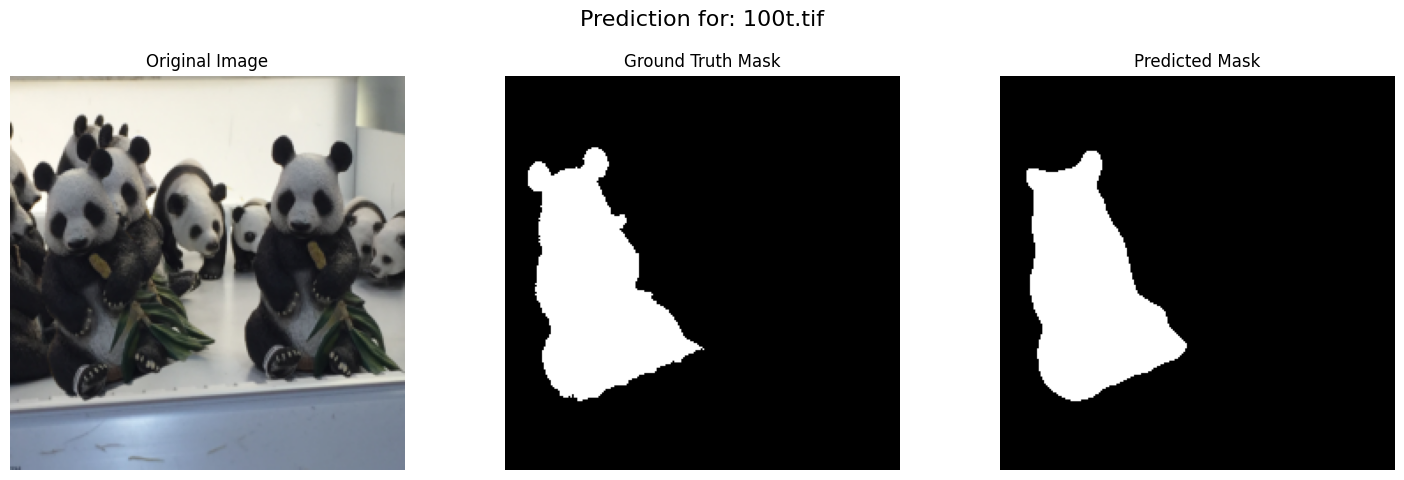


Visualizing COVERAGE (Scratch) Test Sample (Index 1): 10t.tif


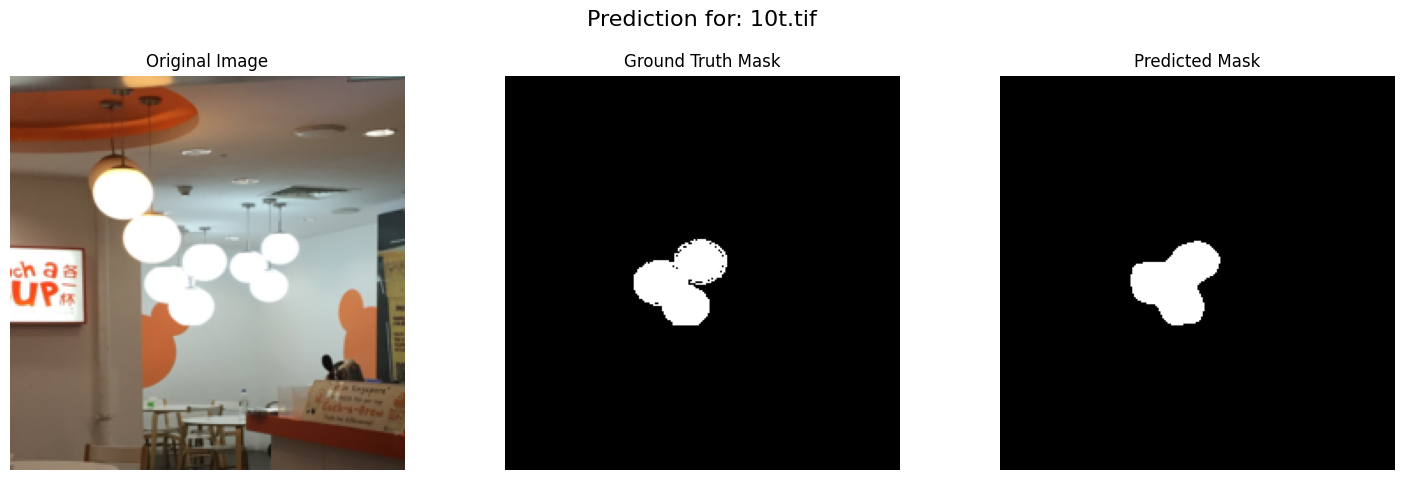


Visualizing COVERAGE (Scratch) Test Sample (Index 2): 16t.tif


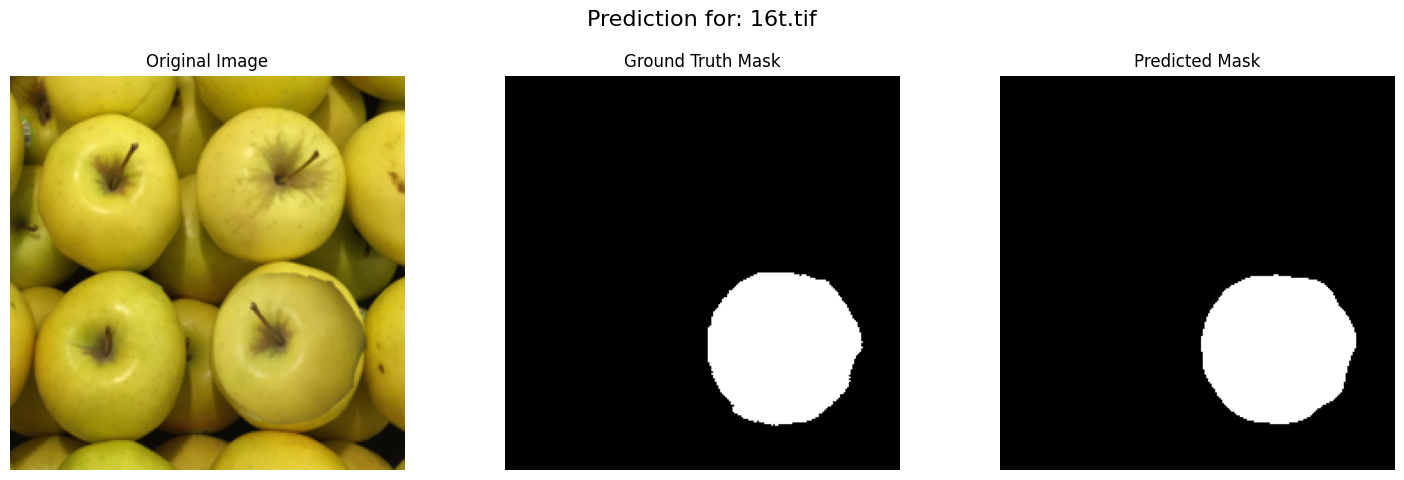


Visualizing COVERAGE (Scratch) Test Sample (Index 3): 17t.tif


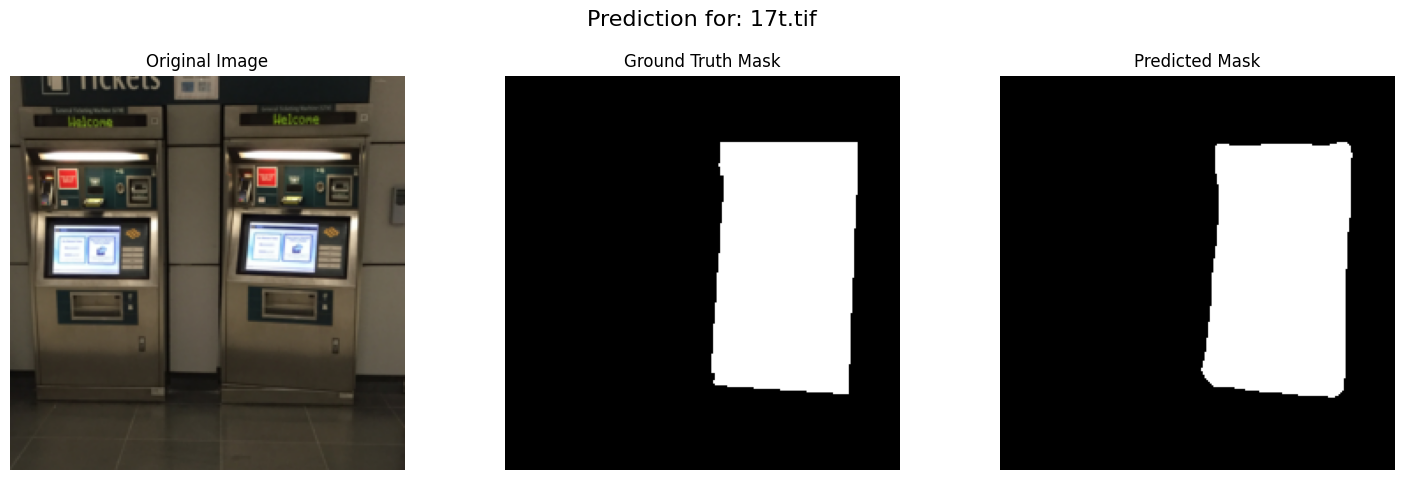


Visualizing COVERAGE (Scratch) Test Sample (Index 4): 1t.tif


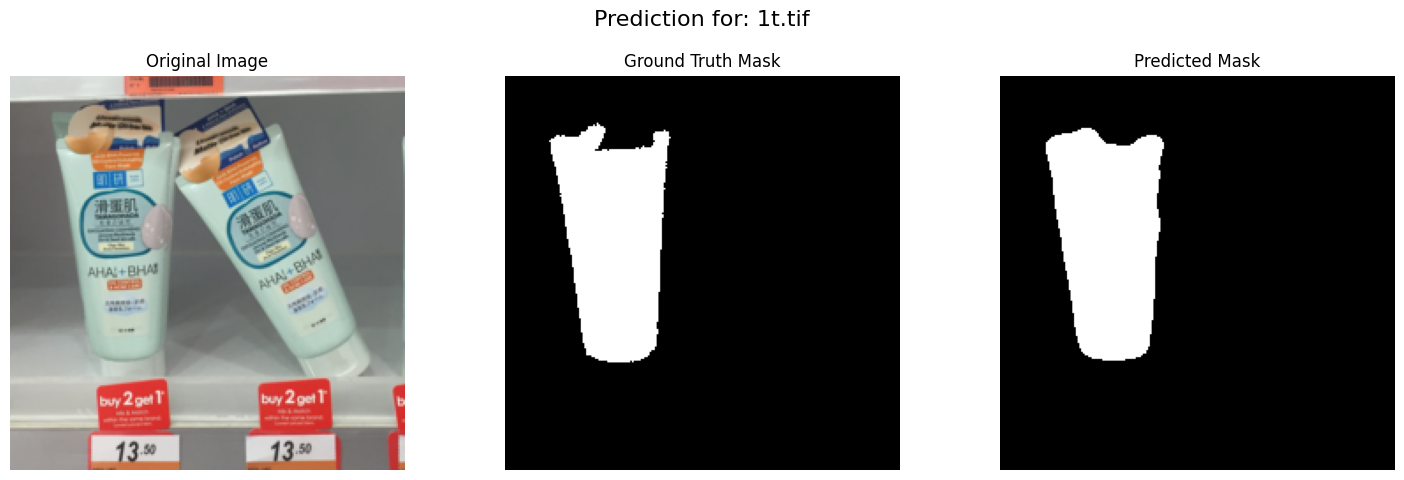


Visualizing COVERAGE (Scratch) Test Sample (Index 5): 20t.tif


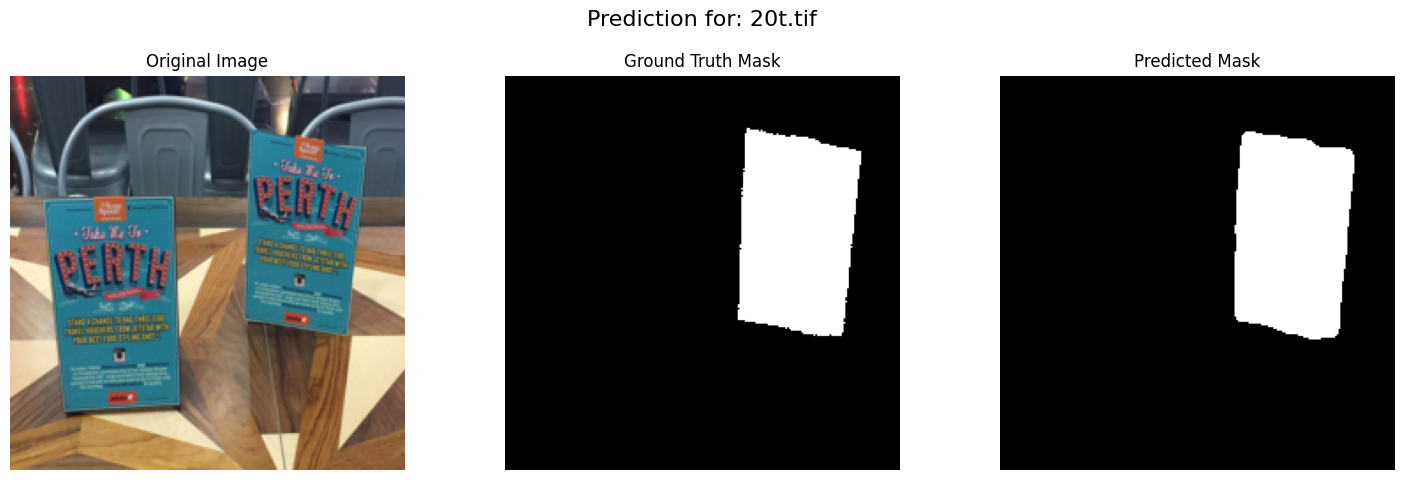


Visualizing COVERAGE (Scratch) Test Sample (Index 6): 21t.tif


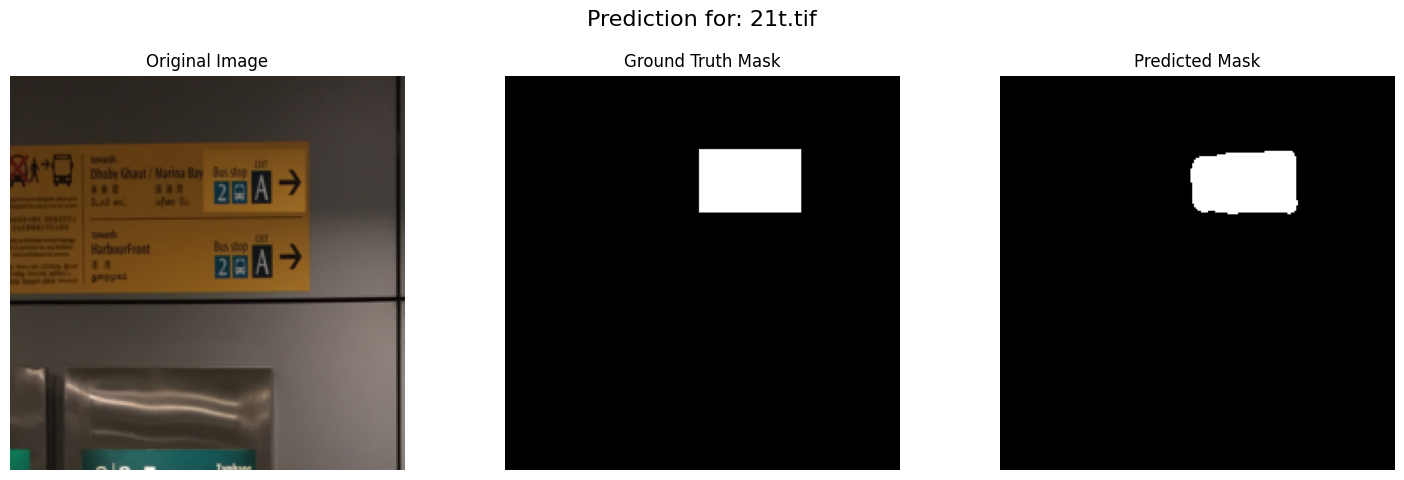


Visualizing COVERAGE (Scratch) Test Sample (Index 26): 52t.tif


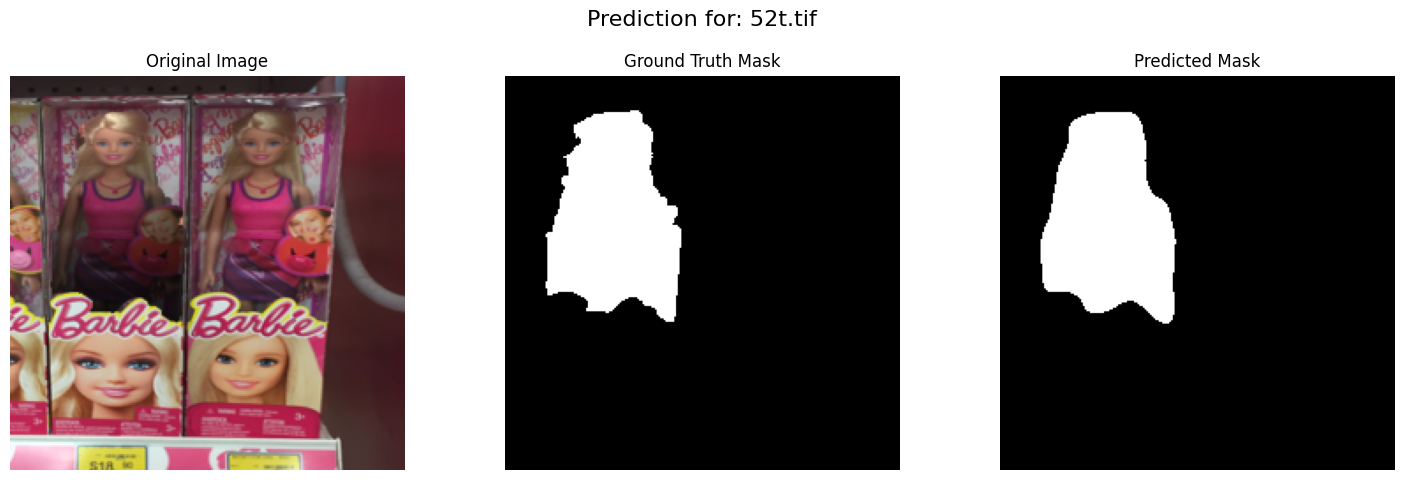


Visualizing COVERAGE (Scratch) Test Sample (Index 52): 99t.tif


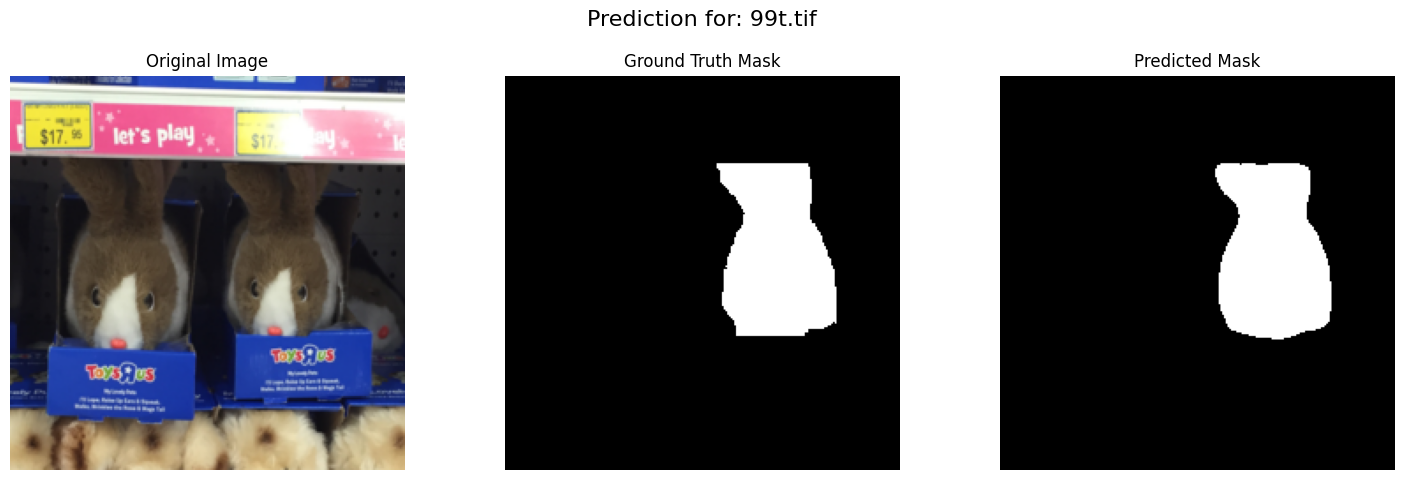


COVERAGE (Scratch) Visualization complete.


In [19]:
# Visualize Predictions for COVERAGE (Scratch)

print("\n--- Visualizing COVERAGE (Scratch) Test Set Predictions ---")

# Select a few diverse indices from the test set for visualization
# test_dataset_coverage_eval is CMFDataset_COVERAGE_Split
# It's a direct Dataset, so we can index it directly.
indices_to_visualize = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    # First image
    len(test_dataset_coverage_eval) // 2,   # Middle image
    len(test_dataset_coverage_eval) - 1     # Last image
]

if len(test_dataset_coverage_eval) == 0:
    print("No COVERAGE test samples to visualize. Please check dataset loading.")
else:
    for idx in indices_to_visualize:
        if 0 <= idx < len(test_dataset_coverage_eval):
            # CMFDataset_COVERAGE_Split.data_pairs stores (image_path, mask_path) directly
            image_path, mask_path = test_dataset_coverage_eval.data_pairs[idx]

            print(f"\nVisualizing COVERAGE (Scratch) Test Sample (Index {idx}): {os.path.basename(image_path)}")
            visualize_single_prediction(model_coverage_scratch, image_path, mask_path, device, MODEL_INPUT_TRANSFORM, DISPLAY_IMAGE_TRANSFORM)
        else:
            print(f"Skipping visualization: Index {idx} is out of bounds for COVERAGE test dataset ({len(test_dataset_coverage_eval)} samples).")

print("\nCOVERAGE (Scratch) Visualization complete.")

In [20]:
# Calculate Metrics for COVERAGE (Scratch)

print("\n--- Starting COVERAGE (Scratch) Test Set Metric Calculation ---")
iou_coverage_scratch, f1_coverage_scratch, precision_coverage_scratch, recall_coverage_scratch = \
    calculate_metrics(model_coverage_scratch, test_loader_coverage_eval, device)
print("\n--- COVERAGE (Scratch) Test Set Metric Calculation Complete ---")


--- Starting COVERAGE (Scratch) Test Set Metric Calculation ---


Calculating Metrics:   0%|          | 0/27 [00:00<?, ?it/s]


--- Overall Metrics on COVERAGE Test Set ---
  IoU: 0.9526
  F1-Score: 0.9757
  Precision: 0.9794
  Recall: 0.9721

--- COVERAGE (Scratch) Test Set Metric Calculation Complete ---
